Library imports

In [1]:
import rasterio
import seaborn as sns
from sklearn.metrics import roc_auc_score
from shapely import wkt

import utilities as utils

Loads the datacube

In [2]:
data = utils.load_dataset('data2/2021_Table04_Datacube.csv')
data.head()

,"ï»¿""H3_Address""",H3_Resolution,H3_Geometry,Longitude_EPSG4326,Latitude_EPSG4326,Continent_Majority,Continent_Minority,Country_Majority,Country_Minority,Province_Majority,...,Litmod_Density_Asthenosphere,Litmod_Density_Crust,Litmod_Density_Lithosphere,Crust1_Type,Crust1_CrustalThickness,Crust1_SedimentThickness,Training_MVT_Deposit,Training_MVT_Occurrence,Training_CD_Deposit,Training_CD_Occurrence
0,8712e579bffffff,7,"POLYGON ((-115.0314 54.5077, -115.0393 54.4961...",-115.018142,54.497221,North America,North America,Canada,Canada,Alberta,...,3480.580078,2891.260254,3337.300049,island arc,-38.450497,2991.459961,Absent,Absent,Absent,Absent
1,8712e579affffff,7,"POLYGON ((-115.0658 54.51706, -115.0737 54.505...",-115.052542,54.506590,North America,North America,Canada,Canada,Alberta,...,3480.580078,2891.260010,3337.300293,island arc,-38.430000,3000.000244,Absent,Absent,Absent,Absent
2,8712e56b4ffffff,7,"POLYGON ((-115.0604 54.49501, -115.0682 54.483...",-115.047107,54.484541,North America,North America,Canada,Canada,Alberta,...,3480.580078,2891.259766,3337.300049,island arc,-38.430000,3000.000000,Absent,Absent,Absent,Absent
3,8712e56b5ffffff,7,"POLYGON ((-115.026 54.48564, -115.0338 54.4740...",-115.012729,54.475169,North America,North America,Canada,Canada,Alberta,...,3480.580078,2891.260010,3337.300049,island arc,-38.591599,2932.666504,Absent,Absent,Absent,Absent
4,8712e56a6ffffff,7,"POLYGON ((-114.997 54.49832, -115.0049 54.4867...",-114.983753,54.487840,North America,North America,Canada,Canada,Alberta,...,3480.580078,2891.260010,3337.300049,island arc,-39.815273,2422.801758,Absent,Absent,Absent,Absent


In [3]:
# modifies presence / absence columns to boolean - geology properties
data["Geology_Dictionary_Alkalic"] = data["Geology_Dictionary_Alkalic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Anatectic"] = data["Geology_Dictionary_Anatectic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Calcareous"] = data["Geology_Dictionary_Calcareous"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Carbonaceous"] = data["Geology_Dictionary_Carbonaceous"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Cherty"] = data["Geology_Dictionary_Cherty"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_CoarseClastic"] = data["Geology_Dictionary_CoarseClastic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Evaporitic"] = data["Geology_Dictionary_Evaporitic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Felsic"] = data["Geology_Dictionary_Felsic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_FineClastic"] = data["Geology_Dictionary_FineClastic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Gneissose"] = data["Geology_Dictionary_Gneissose"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Igneous"] = data["Geology_Dictionary_Igneous"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Intermediate"] = data["Geology_Dictionary_Intermediate"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Pegmatitic"] = data["Geology_Dictionary_Pegmatitic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_RedBed"] = data["Geology_Dictionary_RedBed"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Schistose"] = data["Geology_Dictionary_Schistose"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Sedimentary"] = data["Geology_Dictionary_Sedimentary"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_UltramaficMafic"] = data["Geology_Dictionary_UltramaficMafic"].apply(lambda x: True if x == "Present" else False)
# modifies presence / absence columns to boolean - labels
data["Training_MVT_Deposit"] = data["Training_MVT_Deposit"].apply(lambda x: True if x == "Present" else False)
data["Training_MVT_Occurrence"] = data["Training_MVT_Occurrence"].apply(lambda x: True if x == "Present" else False)
data["Training_CD_Deposit"] = data["Training_CD_Deposit"].apply(lambda x: True if x == "Present" else False)
data["Training_CD_Occurrence"] = data["Training_CD_Occurrence"].apply(lambda x: True if x == "Present" else False)

Selects the data /labels used for MVT WOE baseline

In [4]:
cols_dict = utils.load_features_dict(type='MVT', baseline='ours')
data_filtered, cols = utils.extract_cols(data, cols_dict)

data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5164970 entries, 0 to 5164969
Data columns (total 27 columns):
 #   Column                                          Dtype  
---  ------                                          -----  
 0   H3_Geometry                                     object 
 1   Continent_Majority                              object 
 2   Geology_Lithology_Majority                      object 
 3   Geology_Period_Maximum_Majority                 object 
 4   Geology_Period_Minimum_Majority                 object 
 5   Sedimentary_Dictionary                          bool   
 6   Igneous_Dictionary                              bool   
 7   Metamorphic_Dictionary                          bool   
 8   Seismic_LAB_Priestley                           float64
 9   Seismic_Moho                                    float64
 10  Gravity_GOCE_ShapeIndex                         float64
 11  Geology_Paleolatitude_Period_Minimum            float64
 12  Terrane_Proximity           

The following function finds all the neighbors and creates a new column "MVT_Deposit".
Original paper treats neighbors of polygons with "Training_MVT_Deposit=Present" and "Training_MVT_Occurrence=Present" as mineral present, "MVT_Deposit=Present" (note: now Deposit means - Deposit, Occurrence, or their neighbor). 

In [5]:
data_filtered = utils.neighbor_deposits(data_filtered, type='MVT')

In [6]:
print(data_filtered['MVT_Deposit'].value_counts())
print(data_filtered['MVT_Deposit_wNeighbors'].value_counts())

MVT_Deposit
False    5162943
True        2027
Name: count, dtype: int64
MVT_Deposit_wNeighbors
False    5155482
True        9488
Name: count, dtype: int64


In [7]:
labels_filtered = data_filtered['MVT_Deposit_wNeighbors']
geometry_filtered = data_filtered["H3_Geometry"]
continent_filtered = data_filtered["Continent_Majority"]
data_filtered = data_filtered.drop(columns=['H3_Geometry', 'Continent_Majority', 'Training_MVT_Deposit', 'Training_MVT_Occurrence', 'MVT_Deposit', 'MVT_Deposit_wNeighbors'])
cols = cols[2:-2]

Clearly the dataset has MANY outliers, as reported in the paper

/home/local/SRI/e33725/.conda/envs/aie-cmaas-pp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/local/SRI/e33725/.conda/envs/aie-cmaas-pp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/local/SRI/e33725/.conda/envs/aie-cmaas-pp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/local/SRI/e33725/.conda/envs/aie-cmaas-pp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categoric

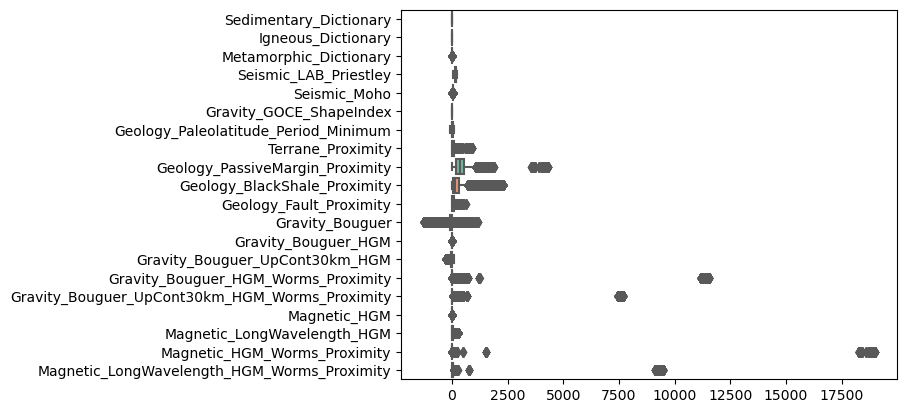

In [8]:
ax = sns.boxplot(data=data_filtered, orient="h", palette="Set2")

We can remove these outliers

/home/local/SRI/e33725/.conda/envs/aie-cmaas-pp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/local/SRI/e33725/.conda/envs/aie-cmaas-pp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/local/SRI/e33725/.conda/envs/aie-cmaas-pp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/local/SRI/e33725/.conda/envs/aie-cmaas-pp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categoric

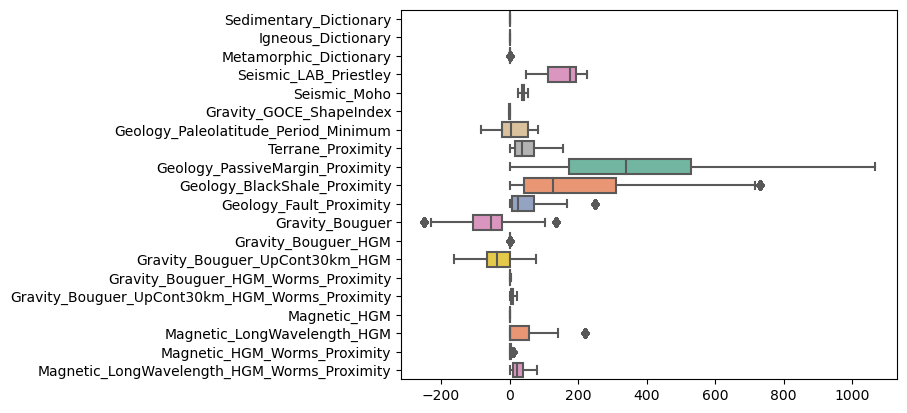

In [9]:
data_filtered = utils.tukey_remove_outliers(data_filtered)
ax = sns.boxplot(data=data_filtered, orient="h", palette="Set2")

There are also many NaNs in the data, these can be "imputed" with the mean value.

In [10]:
print(data_filtered.isna().sum())

Geology_Lithology_Majority                              0
Geology_Period_Maximum_Majority                     44289
Geology_Period_Minimum_Majority                     44289
Sedimentary_Dictionary                                  0
Igneous_Dictionary                                      0
Metamorphic_Dictionary                                  0
Seismic_LAB_Priestley                                   0
Seismic_Moho                                         1307
Gravity_GOCE_ShapeIndex                                 0
Geology_Paleolatitude_Period_Minimum              1039588
Terrane_Proximity                                       0
Geology_PassiveMargin_Proximity                         0
Geology_BlackShale_Proximity                            0
Geology_Fault_Proximity                                 0
Gravity_Bouguer                                     36401
Gravity_Bouguer_HGM                                 36445
Gravity_Bouguer_UpCont30km_HGM                      36427
Gravity_Bougue

In [11]:
data_filtered = utils.impute_nans(data_filtered)
print(data_filtered.isna().sum())

Geology_Lithology_Majority                        0
Geology_Period_Maximum_Majority                   0
Geology_Period_Minimum_Majority                   0
Sedimentary_Dictionary                            0
Igneous_Dictionary                                0
Metamorphic_Dictionary                            0
Seismic_LAB_Priestley                             0
Seismic_Moho                                      0
Gravity_GOCE_ShapeIndex                           0
Geology_Paleolatitude_Period_Minimum              0
Terrane_Proximity                                 0
Geology_PassiveMargin_Proximity                   0
Geology_BlackShale_Proximity                      0
Geology_Fault_Proximity                           0
Gravity_Bouguer                                   0
Gravity_Bouguer_HGM                               0
Gravity_Bouguer_UpCont30km_HGM                    0
Gravity_Bouguer_HGM_Worms_Proximity               0
Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity    0
Magnetic_HGM

Finally, it can be observed the above data is not "normalized", we should make features standard scores / z-scores

/home/local/SRI/e33725/.conda/envs/aie-cmaas-pp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/local/SRI/e33725/.conda/envs/aie-cmaas-pp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/local/SRI/e33725/.conda/envs/aie-cmaas-pp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/local/SRI/e33725/.conda/envs/aie-cmaas-pp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categoric

(note remaining outliers above were within the Tukey fences calculated over ALL the data)


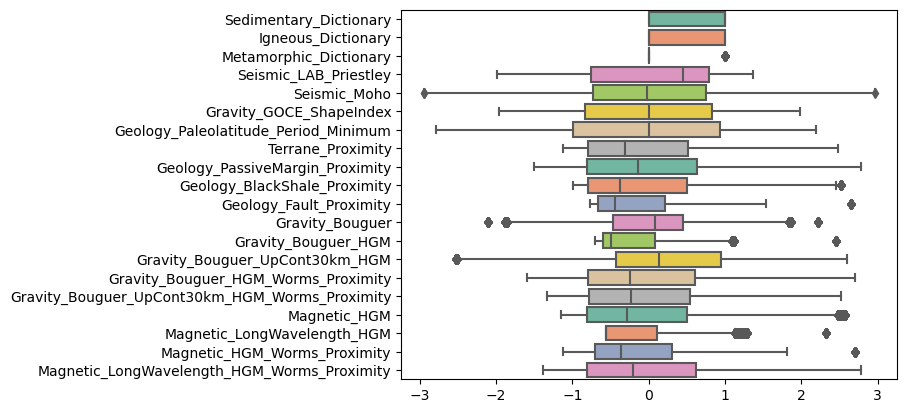

In [12]:
data_filtered = utils.normalize_df(data_filtered)
ax = sns.boxplot(data=data_filtered, orient="h", palette="Set2")
print("(note remaining outliers above were within the Tukey fences calculated over ALL the data)")

Adds back the labels, geometry, and continent

In [13]:
data_filtered["target"] = labels_filtered
data_filtered["H3_Geometry"] = geometry_filtered
data_filtered["Continent_Majority"] = continent_filtered

data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5164970 entries, 0 to 5164969
Data columns (total 26 columns):
 #   Column                                          Dtype  
---  ------                                          -----  
 0   Geology_Lithology_Majority                      object 
 1   Geology_Period_Maximum_Majority                 object 
 2   Geology_Period_Minimum_Majority                 object 
 3   Sedimentary_Dictionary                          bool   
 4   Igneous_Dictionary                              bool   
 5   Metamorphic_Dictionary                          bool   
 6   Seismic_LAB_Priestley                           float64
 7   Seismic_Moho                                    float64
 8   Gravity_GOCE_ShapeIndex                         float64
 9   Geology_Paleolatitude_Period_Minimum            float64
 10  Terrane_Proximity                               float64
 11  Geology_PassiveMargin_Proximity                 float64
 12  Geology_BlackShale_Proximity

Generates tiff files for every column, separate for US/Canada and Australia

In [14]:
continents = ["Oceania", "North America"]

bounds = [
    {'left':112.9, 'bottom':-43.6, 'right':153.6, 'top':-9.5},
    {'left':-187.5, 'bottom':24.5, 'right':-52.6, 'top':83.15}
]

resolution = (0.008, 0.008)

data_filtered["H3_Geometry"] = data_filtered["H3_Geometry"].apply(wkt.loads)

nodata_value = rasterio.open("./data2/GeophysicsGravity_Australia.tif").nodata

for idx, continent in enumerate(continents):
    print(f"Rasterizing {continent}")
    continent_datacube = data_filtered[data_filtered["Continent_Majority"] == continent]

    height = int((bounds[idx]["top"]-bounds[idx]["bottom"]) / resolution[0])
    width = int((bounds[idx]["right"]-bounds[idx]["left"]) / resolution[1])

    tif_tf = rasterio.transform.from_bounds(
        bounds[idx]["left"],
        bounds[idx]["bottom"],
        bounds[idx]["right"],
        bounds[idx]["top"],
        width,
        height
    )

    tiff_meta = {
        "driver": 'GTiff',
        "height": height,
        "width": width,
        "count": 1,
        "dtype": "float64",
        "crs": rasterio.CRS.from_epsg(4326),
        "transform": tif_tf,
        "nodata": nodata_value,
        "compress": "lzw",
    }

    utils.rasterize_datacube(continent_datacube, tiff_meta, './data2/', continent.lower().replace(" ","-"))

Rasterizing Oceania


/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datacube["target"] = datacube["target"].astype("float64")
/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:372: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datacube["Sedimentary_Dictionary"] = datacube["Sedimentary_Dictionary"].astype("float64")
/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Rasterizing North America


/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datacube["target"] = datacube["target"].astype("float64")
/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:372: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datacube["Sedimentary_Dictionary"] = datacube["Sedimentary_Dictionary"].astype("float64")
/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram